In [1]:
# import libraries
import numpy as np
import os #operation system
import pickle
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 5)
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import models, layers, activations
from keras.models import Model
from PIL import Image, ImageFilter
from keras import regularizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras.optimizers import Adam

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4881959115768908545
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2918187008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11178285363510334906
physical_device_desc: "device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [2]:
fashion = keras.datasets.fashion_mnist
(xtrain, ytrain), (xtest, ytest) = fashion.load_data()

In [3]:
fashion = keras.datasets.fashion_mnist
(xtrain, ytrain), (xtest, ytest) = fashion.load_data()

In [4]:
xtrain = xtrain.reshape(-1, 28, 28, 1)  # Reshape to (6000, 28, 28, 1) for grayscale images

xtrain = xtrain.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

In [5]:
ls = 'CategoricalCrossentropy' # define the (string) loss function
lr = 0.1 # pick a value for your learning rate
metric = ['acc'] # define (Python) list of metrics

# Custom parameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
decay = 0.0
amsgrad = False

# Initialize Adam optimizer
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay, amsgrad=amsgrad)


In [6]:

# Check the list of visible devices
visible_devices = tf.config.get_visible_devices()
gpu_devices = [device.name for device in visible_devices if device.device_type == 'GPU']

if len(gpu_devices) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu_device in gpu_devices:
        print(gpu_device)
else:
    print("TensorFlow is not using any GPU. It's running on CPU.")


TensorFlow is using the following GPU(s):
/physical_device:GPU:0


In [7]:
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    # Reshape your data to (6000, 28, 28, 1) for grayscale images
    x_training = x_training.reshape(-1, 28, 28, 1)
    x_validation = x_validation.reshape(-1, 28, 28, 1)

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training, y_training, batch_size=batch_size, epochs=1, verbose=0)

        # Get training loss and accuracy
        training_loss = results.history['loss'][0]
        training_accuracy = results.history['accuracy'][0]

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=batch_size, verbose=0)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(tra_losses)), tra_losses, 'b', label='training loss')
        plt.plot(range(len(tra_accs)), tra_accs, 'c', label='training accuracy')
        plt.plot(range(len(val_losses)), val_losses, 'm', label='validation loss')
        plt.plot(range(len(val_accs)), val_accs, 'r', label='validation accuracy')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.2)

In [8]:
batch_size = 128 #hardware-based
n_epoch = 10

file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_net_task_2.h5')

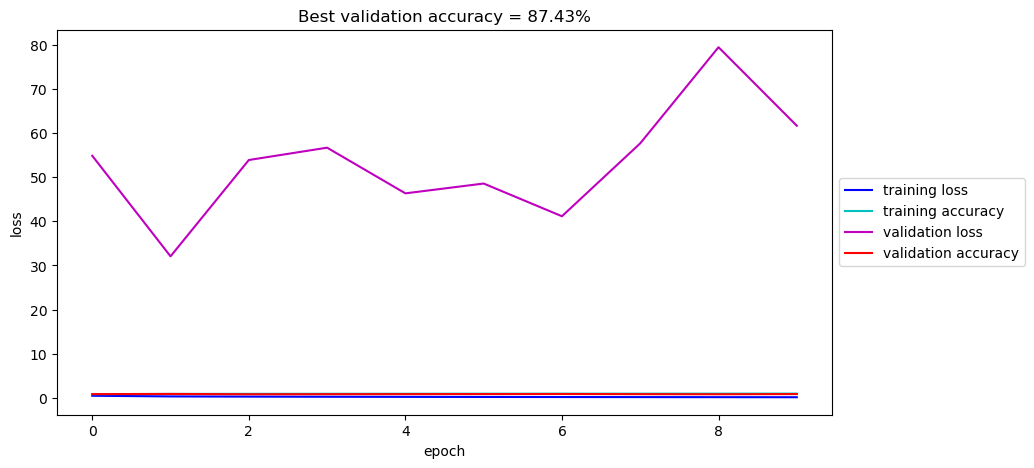

In [9]:
# Assuming you have built and compiled the model as shown before
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Assuming you have 10 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Call the training function
train_network(model, xtrain, ytrain, xtest, ytest, n_epoch=10, batch_size=32, network_filepath='best_model.h5')
